In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

# Acquisition - Tensorflow Input Pipeline

In [21]:
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [6]:
# Load images from directory
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    # Randomly shuffle the images and load
    shuffle = True,
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [7]:
# Store class names into variable
class_names = dataset.class_names
class_names

['early_blight', 'healthy', 'late_blight']

In [8]:
# Each batch of the image is 32 images, we have 68 batches
len(dataset)

68

In [10]:
# Printing shape of batches
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[2 0 0 2 2 2 0 0 0 0 2 0 2 0 0 2 2 2 0 2 0 2 0 2 0 0 0 0 2 2 2 2]


In [16]:
# Printing shape of the first image
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].shape)

(256, 256, 3)


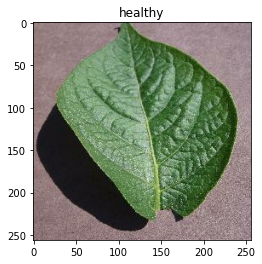

In [18]:
# Print first image (each time image display would be different due to shuffle randomness)
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    # Print image classname
    plt.title(class_names[label_batch[0]])

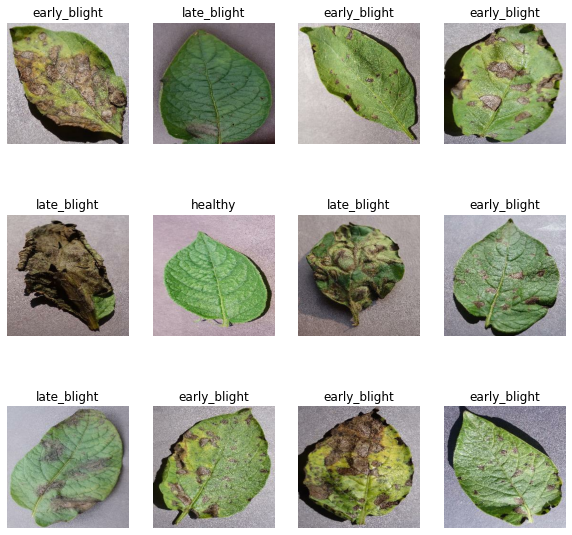

In [20]:
plt.figure(figsize = (10, 10))
# Print first 12 images
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        # Print image classname
        plt.title(class_names[label_batch[i]])
        
        # Turn off axis
        plt.axis('off')

# Splitting Data

80% ==> training

20% ==> 10% validation, 10% test

In [22]:
# Split train dataset
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [23]:
train = dataset.take(54)
len(train)

54

In [28]:
# Store the remaining 20% of the data to a variable
rest = dataset.skip(54)
len(rest)

14

In [25]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [29]:
# Split validate from the remaining 20% of data
validate = rest.take(6)
len(validate)

6

In [30]:
# Define test dataset
test = rest.skip(6)
len(test)

8

In [35]:
# Define function to split data
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1,
                             shuffle=True, shuffle_size = 10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train = ds.take(train_size)
    validate = ds.skip(train_size).take(val_size)
    test = ds.skip(train_size).skip(val_size)
    return train, validate, test

In [36]:
# Calling function to split data
train, validate, test = get_dataset_partitions_tf(dataset)

In [39]:
len(train), len(validate), len(test)

(54, 6, 8)

In [38]:
# Cache data and optimize speed
train = train.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
validate = validate.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test = test.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

# Image Processing

In [43]:
# Resize and rescale image
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(256,256),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [44]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

# Modeling

In [48]:
# Define neural network architecture
n_classes = 3
# input shape = image size, channel
input_shape = (BATCH_SIZE, 256,256,CHANNELS)
# Set layers of model
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    # Convolution + reLu
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
    # Pooling
    layers.MaxPooling2D((2,2)),
    # Repeat
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    # softmax normalized probability of classes
    layers.Dense(n_classes,activation = 'softmax'),
                  
])
model.build(input_shape = input_shape)

In [49]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (256, 256, 3)             0         
                                                                 
 sequential_1 (Sequential)   (256, 256, 3)             0         
                                                                 
 conv2d_12 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                 

In [50]:
# Compile using optimizer
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [51]:
history = model.fit(
    train,
    epochs=EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = validate
)

Epoch 1/50
54/54 [==============================] - 52s 929ms/step - loss: 0.8641 - accuracy: 0.5550 - val_loss: 0.7346 - val_accuracy: 0.6302
Epoch 2/50
54/54 [==============================] - 47s 870ms/step - loss: 0.5959 - accuracy: 0.7431 - val_loss: 0.4263 - val_accuracy: 0.8490
Epoch 3/50
54/54 [==============================] - 43s 788ms/step - loss: 0.4560 - accuracy: 0.8108 - val_loss: 0.3091 - val_accuracy: 0.8698
Epoch 4/50
54/54 [==============================] - 47s 866ms/step - loss: 0.2776 - accuracy: 0.8895 - val_loss: 0.3492 - val_accuracy: 0.8802
Epoch 5/50
54/54 [==============================] - 43s 801ms/step - loss: 0.2421 - accuracy: 0.9068 - val_loss: 0.2251 - val_accuracy: 0.9062
Epoch 6/50
54/54 [==============================] - 46s 851ms/step - loss: 0.1912 - accuracy: 0.9271 - val_loss: 0.2845 - val_accuracy: 0.8958
Epoch 7/50
54/54 [==============================] - 45s 836ms/step - loss: 0.1615 - accuracy: 0.9387 - val_loss: 0.3399 - val_accuracy: 0.8594

54/54 [==============================] - 43s 788ms/step - loss: 0.0272 - accuracy: 0.9890 - val_loss: 0.1041 - val_accuracy: 0.9583
Epoch 40/50
54/54 [==============================] - 43s 792ms/step - loss: 0.0349 - accuracy: 0.9896 - val_loss: 0.0547 - val_accuracy: 0.9792
Epoch 41/50
54/54 [==============================] - 45s 832ms/step - loss: 0.0317 - accuracy: 0.9890 - val_loss: 0.0660 - val_accuracy: 0.9740
Epoch 42/50
54/54 [==============================] - 46s 854ms/step - loss: 0.0221 - accuracy: 0.9896 - val_loss: 0.0660 - val_accuracy: 0.9740
Epoch 43/50
54/54 [==============================] - 46s 852ms/step - loss: 0.0434 - accuracy: 0.9873 - val_loss: 0.3570 - val_accuracy: 0.8958
Epoch 44/50
54/54 [==============================] - 46s 851ms/step - loss: 0.0322 - accuracy: 0.9884 - val_loss: 0.1280 - val_accuracy: 0.9635
Epoch 45/50
54/54 [==============================] - 47s 863ms/step - loss: 0.0355 - accuracy: 0.9873 - val_loss: 0.0608 - val_accuracy: 0.9688
Epoc

In [52]:
# Evaluate model on test dataset
scores = model.evaluate(test)

8/8 [==============================] - 2s 187ms/step - loss: 0.0582 - accuracy: 0.9805


In [53]:
# First parameter -> lost, second parameter -> accuracy
scores

[0.05818914622068405, 0.98046875]

In [54]:
history

In [55]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [56]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [58]:
# Look at all epoch accuracy
history.history['accuracy']

[0.5549768805503845,
 0.7430555820465088,
 0.8107638955116272,
 0.8894675970077515,
 0.9068287014961243,
 0.9270833134651184,
 0.9386574029922485,
 0.9207175970077515,
 0.9542824029922485,
 0.9623842835426331,
 0.9618055820465088,
 0.9670138955116272,
 0.9641203880310059,
 0.9733796119689941,
 0.9809027910232544,
 0.9756944179534912,
 0.9658564925193787,
 0.9641203880310059,
 0.9791666865348816,
 0.9826388955116272,
 0.9837962985038757,
 0.9809027910232544,
 0.9739583134651184,
 0.9745370149612427,
 0.9855324029922485,
 0.9832175970077515,
 0.9878472089767456,
 0.9855324029922485,
 0.9895833134651184,
 0.9872685074806213,
 0.9652777910232544,
 0.9774305820465088,
 0.9895833134651184,
 0.9837962985038757,
 0.9809027910232544,
 0.9878472089767456,
 0.9895833134651184,
 0.9930555820465088,
 0.9890046119689941,
 0.9895833134651184,
 0.9890046119689941,
 0.9895833134651184,
 0.9872685074806213,
 0.9884259104728699,
 0.9872685074806213,
 0.9855324029922485,
 0.9924768805503845,
 0.9907407164

In [59]:
# Storing accuracy and loss into variables for visualization
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

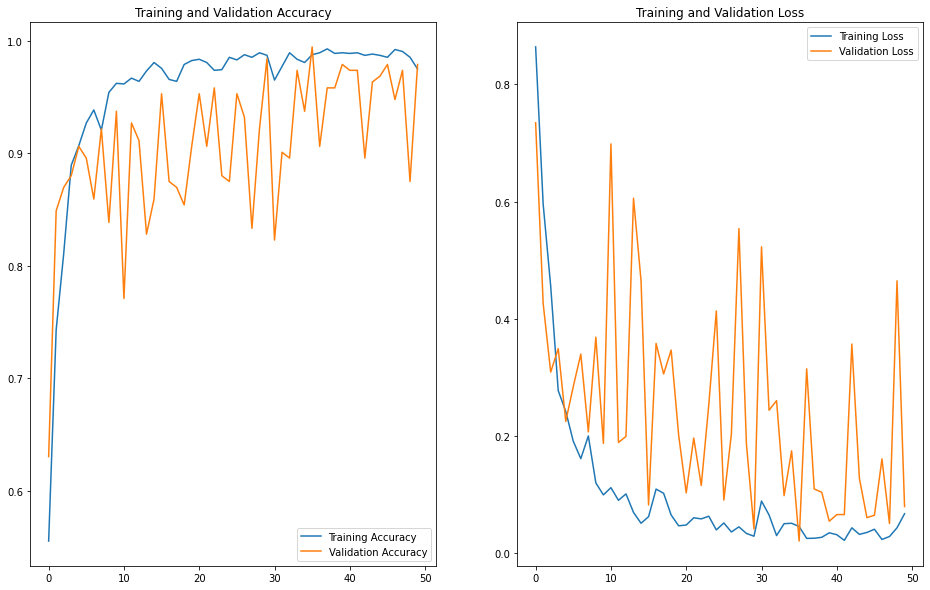

In [64]:
plt.figure(figsize = (16,10))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

#### Make Predictions

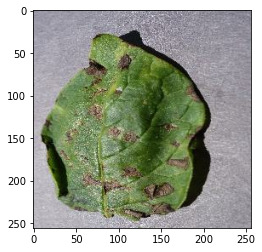

In [67]:
# Print first image
for images_batch, labels_batch in test.take(1):
    plt.imshow(images_batch[0].numpy().astype('uint8'))

In [68]:
for images_batch, labels_batch in test.take(1):
    print(images_batch[0].numpy().astype('uint8'))

[[[109  96 103]
  [114 101 108]
  [113 100 107]
  ...
  [133 123 131]
  [133 123 131]
  [136 126 134]]

 [[103  90  97]
  [110  97 104]
  [113 100 107]
  ...
  [129 119 127]
  [128 118 126]
  [131 121 129]]

 [[101  88  95]
  [105  92  99]
  [108  95 102]
  ...
  [127 117 125]
  [128 118 126]
  [132 122 130]]

 ...

 [[115 103 113]
  [ 97  85  95]
  [ 99  87  97]
  ...
  [137 129 140]
  [143 135 146]
  [152 144 155]]

 [[105  93 103]
  [ 90  78  88]
  [ 90  78  88]
  ...
  [139 131 142]
  [143 135 146]
  [149 141 152]]

 [[ 97  85  95]
  [ 88  76  86]
  [ 86  74  84]
  ...
  [144 136 147]
  [146 138 149]
  [150 142 153]]]


first image to predict
first image's actual label:  early_blight
1/1 [==============================] - 0s 196ms/step
first image's predicted label:  early_blight


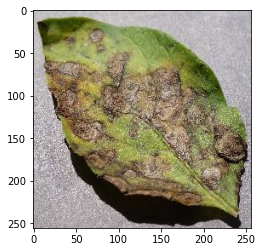

In [76]:
import numpy as np
for images_batch, labels_batch in test.take(1):
    
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0]
    
    print('first image to predict')
    plt.imshow(first_image)
    print("first image's actual label: ", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("first image's predicted label: ", class_names[np.argmax(batch_prediction[0])])

In [84]:
# Create function to return the predicted class and confidence
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 40ms/step


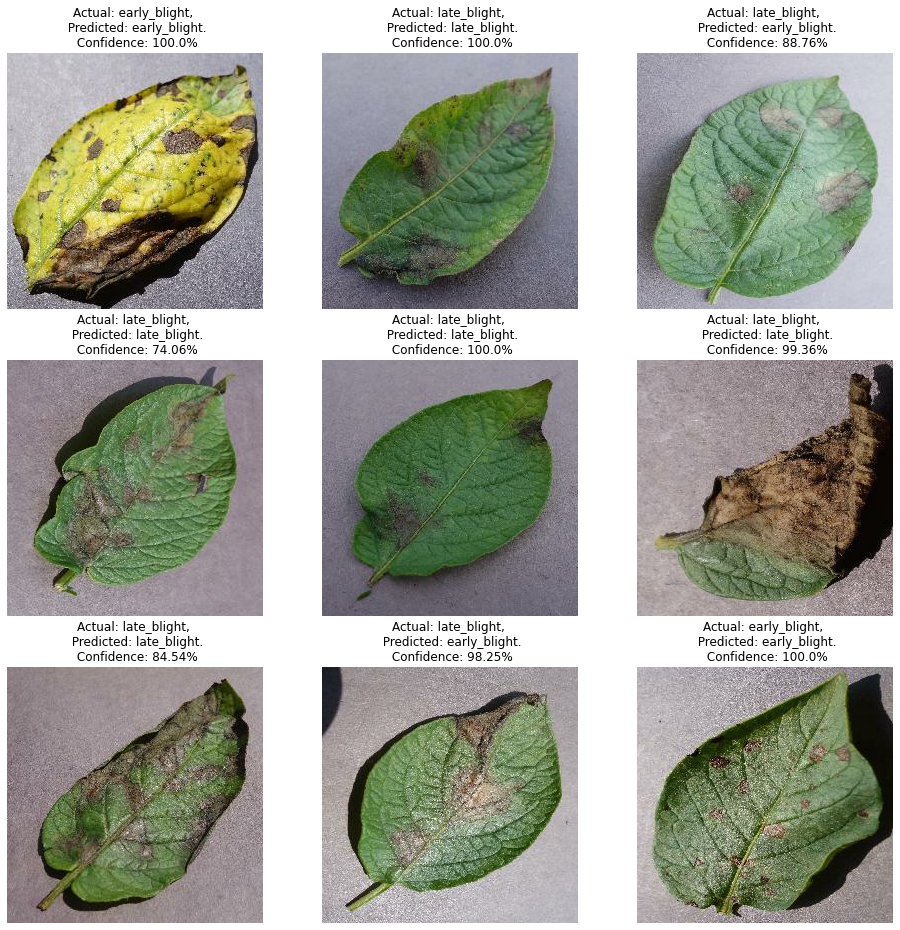

In [86]:
for images, labels in test.take(1):
    plt.figure(figsize = (16,16))
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}.\n Confidence: {confidence}%" )
        plt.axis('off')